## Subscription Data

Author: Vivian

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [4]:
sub = pd.read_csv('/Users/vivianyan/Desktop/NYU_Capstone_Project/Data/XYZ_NETWORKS_SUB_1P_DATA.csv')
sub.describe(include='all')

,ID,BRAND,SUB_STATUS,TERM,AMOUNT,PARTITION_DATE
count,219218,250000,250000,250000,250000.000000,250000
unique,46247,5,4,3,NaN,730
top,301TUHW316,CineQuest,paid,monthly,NaN,2022-12-29
freq,28,74818,124780,162765,NaN,396
mean,NaN,NaN,NaN,NaN,31.133457,NaN
std,NaN,NaN,NaN,NaN,28.574427,NaN
min,NaN,NaN,NaN,NaN,2.400000,NaN
25%,NaN,NaN,NaN,NaN,11.990000,NaN
50%,NaN,NaN,NaN,NaN,20.000000,NaN
75%,NaN,NaN,NaN,NaN,49.990000,NaN


In [5]:
sub.head()

,ID,BRAND,SUB_STATUS,TERM,AMOUNT,PARTITION_DATE
0,042MSTJ610,CineQuest,trial,monthly,11.41,2022-10-09
1,020TBXH154,ChillStream,paid,monthly,25.00,2022-08-04
2,367MQHB590,Pulse,paid,monthly,8.01,2023-08-10
3,805HIRQ868,RetroReel,expired,annual,119.99,2023-11-05
4,150UITM842,LimeLight,paid,monthly,20.02,2022-03-02


### Data Cleaning
#### Fix Incorrectly Imputed `daily` Values:
<div class="alert alert-info">
Daily is an incorrectly imputed value for monthly. The only two valid values for term should be annual or monthly.
</div>

In [6]:
sub.TERM.unique()

array(['monthly', 'annual', 'daily'], dtype=object)

In [7]:
sub['TERM'] = sub['TERM'].replace('daily', 'monthly')
sub.TERM.unique()

array(['monthly', 'annual'], dtype=object)

#### Ensure No Duplicate Events per ID/Brand per Month:
<div class="alert alert-info">
No ID should have 2 events in the same month within a specific brand 

- This can be determined using the partition date field
</div>

In [8]:
sub['YEAR_MONTH'] = pd.to_datetime(sub['PARTITION_DATE']).dt.to_period('M')
sub.head()

,ID,BRAND,SUB_STATUS,TERM,AMOUNT,PARTITION_DATE,YEAR_MONTH
0,042MSTJ610,CineQuest,trial,monthly,11.41,2022-10-09,2022-10
1,020TBXH154,ChillStream,paid,monthly,25.00,2022-08-04,2022-08
2,367MQHB590,Pulse,paid,monthly,8.01,2023-08-10,2023-08
3,805HIRQ868,RetroReel,expired,annual,119.99,2023-11-05,2023-11
4,150UITM842,LimeLight,paid,monthly,20.02,2022-03-02,2022-03


In [9]:
sub.groupby(['ID', 'YEAR_MONTH', 'BRAND']).agg({'SUB_STATUS':'count'})['SUB_STATUS'].nunique()

1

In [10]:
sub.groupby(['ID', 'YEAR_MONTH', 'BRAND']).agg({'TERM':'count'})['TERM'].nunique()

1

In [11]:
# sub.drop_duplicates(subset=['ID', 'BRAND', 'MONTH_YEAR'], inplace=True)

#### Validate Allowed Transitions Between States:
<div class="alert alert-info">
Transition states will be relevant to SUB_STATUS and TERM columns

- Allowed states for SUB_STATUS:	 
    - trial: paid, expired
    - discounted: paid, expired
    - paid: expired
    - expired: paid, discounted, trial

- An ID who is trial/discounted/paid for one term type (monthly/annual) will need to expire before they can begin a new subscription with the alternative term type
    - i.e. if a sub for Y brand is paid/monthly, and then the next chronological row indicates they are trial/annual, this second transition should be flagged as incorrect and ignored from subscription duration and other calculations
</div>

In [12]:
allowed_transitions = {
    'trial': ['paid', 'expired'],
    'discounted': ['paid', 'expired'],
    'paid': ['expired'],
    'expired': ['paid', 'discounted', 'trial']
}

In [28]:
sub = sub.sort_values(by=['ID', 'BRAND', 'PARTITION_DATE']).reset_index(drop=True)
sub['VALID_TRANSITION'] = True

In [14]:
sub[sub.ID=='000AHHU956']

,ID,BRAND,SUB_STATUS,TERM,AMOUNT,PARTITION_DATE,YEAR_MONTH,VALID_TRANSITION
0,000AHHU956,RetroReel,expired,monthly,30.00,2022-02-17,2022-02,True
1,000AHHU956,RetroReel,paid,monthly,29.99,2022-05-21,2022-05,True
2,000AHHU956,RetroReel,paid,monthly,30.00,2022-08-25,2022-08,True
3,000AHHU956,RetroReel,trial,monthly,28.01,2023-03-09,2023-03,True
4,000AHHU956,RetroReel,paid,monthly,30.02,2023-07-08,2023-07,True
5,000AHHU956,RetroReel,expired,monthly,30.00,2023-10-28,2023-10,True
6,000AHHU956,RetroReel,trial,monthly,11.18,2023-11-05,2023-11,True
7,000AHHU956,RetroReel,discounted,monthly,25.89,2023-12-27,2023-12,True


<div class="alert alert-danger" role="alert">
Questions:

For user 000AHHU956:
1. row2 to row3: status remained unchanged? keep the first occurrence?
2. last row: no closure, status remained unchanged? any deadline or until now?

</div>

In [15]:
sub[sub.ID=='000DJKK225']

,ID,BRAND,SUB_STATUS,TERM,AMOUNT,PARTITION_DATE,YEAR_MONTH,VALID_TRANSITION
11,000DJKK225,CineQuest,expired,monthly,12.00,2022-04-15,2022-04,True
12,000DJKK225,CineQuest,expired,monthly,12.00,2022-06-21,2022-06,True
13,000DJKK225,CineQuest,paid,monthly,12.00,2022-07-17,2022-07,True
14,000DJKK225,CineQuest,paid,monthly,11.97,2022-10-15,2022-10,True
15,000DJKK225,CineQuest,paid,annual,60.00,2023-09-29,2023-09,True


<div class="alert alert-danger" role="alert">
Questions:

For user 000DJKK225:
1. row1 and row2: two expires? keep the latest one?
</div>

In [16]:
sub[sub.ID=='042MSTJ610']

,ID,BRAND,SUB_STATUS,TERM,AMOUNT,PARTITION_DATE,YEAR_MONTH,VALID_TRANSITION
9307,042MSTJ610,CineQuest,expired,annual,59.99,2022-01-29,2022-01,True
9308,042MSTJ610,CineQuest,paid,annual,60.01,2022-02-06,2022-02,True
9309,042MSTJ610,CineQuest,paid,annual,59.99,2022-08-26,2022-08,True
9310,042MSTJ610,CineQuest,trial,monthly,11.41,2022-10-09,2022-10,True
9311,042MSTJ610,CineQuest,expired,monthly,12.00,2022-11-16,2022-11,True


<div class="alert alert-danger" role="alert">
Questions:

For user 042MSTJ610:
1. row1 and row2: paid after expired?
2. row-2 to row-1: can we skip "paid"? or should be strictly followed by the assigend transition table except for "expired"?

</div>

#### Test

In [29]:
test2 = sub.iloc[100:130].reset_index(drop=True)
test2

,ID,BRAND,SUB_STATUS,TERM,AMOUNT,PARTITION_DATE,YEAR_MONTH,VALID_TRANSITION
0,000SJSR665,Pulse,paid,monthly,8.00,2023-05-28,2023-05,True
1,000SJSR665,Pulse,trial,monthly,5.30,2023-10-19,2023-10,True
2,000SJSR665,Pulse,paid,monthly,8.00,2023-11-11,2023-11,True
3,000TFKR237,RetroReel,paid,annual,119.99,2022-03-10,2022-03,True
4,000TMFK922,CineQuest,expired,annual,60.00,2022-11-22,2022-11,True
5,000TMFK922,CineQuest,paid,monthly,12.00,2022-12-24,2022-12,True
6,000TMFK922,CineQuest,expired,monthly,11.99,2023-12-17,2023-12,True
7,000TMFK922,Pulse,paid,annual,50.01,2022-02-14,2022-02,True
8,000TMFK922,Pulse,paid,annual,50.00,2022-07-12,2022-07,True
9,000TMFK922,Pulse,paid,annual,49.99,2023-01-22,2023-01,True


In [30]:
# Validate transitions for each user within each brand
prev, curr = 0, 1
while curr < len(test2):    
    print(prev, curr)
    if test2.iloc[curr]['ID'] == test2.iloc[prev]['ID'] and test2.iloc[curr]['BRAND'] == test2.iloc[prev]['BRAND']:
        prev_status, curr_status = test2.iloc[prev]['SUB_STATUS'], test2.iloc[curr]['SUB_STATUS']
        prev_term, curr_term = test2.iloc[prev]['TERM'], test2.iloc[curr]['TERM']

        if curr_status not in allowed_transitions[prev_status]:
            test2.at[curr, 'VALID_TRANSITION'] = False
            curr += 1
            continue

        if curr_term != prev_term and prev_status != 'expired':
            test2.at[curr, 'VALID_TRANSITION'] = False
            curr += 1
            continue

        if curr_term == prev_term and curr_status == prev_status:
            test2.at[curr, 'VALID_TRANSITION'] = False
            curr += 1
            continue

        prev = curr
        curr += 1

    else:
        prev = curr
        curr += 1

test2

0 1
0 2
0 3
3 4
4 5
5 6
6 7
7 8
7 9
7 10
10 11
11 12
12 13
13 14
14 15
15 16
15 17
17 18
18 19
18 20
20 21
21 22
22 23
23 24
24 25
25 26
25 27
27 28
27 29


,ID,BRAND,SUB_STATUS,TERM,AMOUNT,PARTITION_DATE,YEAR_MONTH,VALID_TRANSITION
0,000SJSR665,Pulse,paid,monthly,8.00,2023-05-28,2023-05,True
1,000SJSR665,Pulse,trial,monthly,5.30,2023-10-19,2023-10,False
2,000SJSR665,Pulse,paid,monthly,8.00,2023-11-11,2023-11,False
3,000TFKR237,RetroReel,paid,annual,119.99,2022-03-10,2022-03,True
4,000TMFK922,CineQuest,expired,annual,60.00,2022-11-22,2022-11,True
5,000TMFK922,CineQuest,paid,monthly,12.00,2022-12-24,2022-12,True
6,000TMFK922,CineQuest,expired,monthly,11.99,2023-12-17,2023-12,True
7,000TMFK922,Pulse,paid,annual,50.01,2022-02-14,2022-02,True
8,000TMFK922,Pulse,paid,annual,50.00,2022-07-12,2022-07,False
9,000TMFK922,Pulse,paid,annual,49.99,2023-01-22,2023-01,False


#### Full Dataset

In [32]:
# Validate transitions for each user within each brand
prev, curr = 0, 1
while curr < len(sub):    
    if sub.iloc[curr]['ID'] == sub.iloc[prev]['ID'] and sub.iloc[curr]['BRAND'] == sub.iloc[prev]['BRAND']:
        prev_status, curr_status = sub.iloc[prev]['SUB_STATUS'], sub.iloc[curr]['SUB_STATUS']
        prev_term, curr_term = sub.iloc[prev]['TERM'], sub.iloc[curr]['TERM']

        if curr_status not in allowed_transitions[prev_status]:
            sub.at[curr, 'VALID_TRANSITION'] = False
            curr += 1
            continue

        if curr_term != prev_term and prev_status != 'expired':
            sub.at[curr, 'VALID_TRANSITION'] = False
            curr += 1
            continue

        if curr_term == prev_term and curr_status == prev_status:
            sub.at[curr, 'VALID_TRANSITION'] = False
            curr += 1
            continue

        prev = curr
        curr += 1

    else:
        prev = curr
        curr += 1

#### Remove Missing Values (ID only):
<div class="alert alert-info">
If data is missing between partition date events for an individual, you can assume there status has remained unchanged/the same until the next valid transition 
</div>

In [33]:
sub_filtered = sub[sub['VALID_TRANSITION'] == True]
sub_filtered.dropna(how='any', inplace=True)
sub_filtered.describe(include='all')

/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_25047/4147286684.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_filtered.dropna(how='any', inplace=True)


,ID,BRAND,SUB_STATUS,TERM,AMOUNT,PARTITION_DATE,YEAR_MONTH,VALID_TRANSITION
count,132587,132587,132587,132587,132587.000000,132587,132587,132587
unique,46247,5,4,2,NaN,730,24,1
top,064PYQT737,CineQuest,paid,monthly,NaN,2022-01-26,2022-01,True
freq,18,33572,66089,95546,NaN,328,9294,132587
mean,NaN,NaN,NaN,NaN,32.478291,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,29.636835,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,2.410000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,11.990000,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,20.010000,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,49.990000,NaN,NaN,NaN


In [34]:
print('Filtered SUB Data Shape: ', sub_filtered.shape)
print('SUB Data Shape: ', sub.shape)

Filtered SUB Data Shape:  (132587, 8)
SUB Data Shape:  (250000, 8)


#### Calculate subcription duratino based on valid transitions:
<div class="alert alert-info">
Subscription start and end date are not provided. Instead partition date (symbolizes when data is refreshed) is provided. 

- You can use partition date as a proxy to calculate the length of duration of a subscription for a specific id (this can be determined by ensuring rows adhere to certain transition states)
</div>

In [35]:
sub_filtered['PARTITION_DATE'] = pd.to_datetime(sub_filtered['PARTITION_DATE'])
sub_filtered = sub_filtered.reset_index(drop=True)
sub_filtered.head()

/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_25047/3221119947.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_filtered['PARTITION_DATE'] = pd.to_datetime(sub_filtered['PARTITION_DATE'])


,ID,BRAND,SUB_STATUS,TERM,AMOUNT,PARTITION_DATE,YEAR_MONTH,VALID_TRANSITION
0,000AHHU956,RetroReel,expired,monthly,30.00,2022-02-17,2022-02,True
1,000AHHU956,RetroReel,paid,monthly,29.99,2022-05-21,2022-05,True
2,000AHHU956,RetroReel,expired,monthly,30.00,2023-10-28,2023-10,True
3,000AHHU956,RetroReel,trial,monthly,11.18,2023-11-05,2023-11,True
4,000BRHY264,CineQuest,paid,annual,60.00,2022-05-23,2022-05,True


In [54]:
sub_duration_data = []
grouped = sub_filtered.groupby(['ID', 'BRAND'])

for (id_brand, group) in grouped:
    group = group.reset_index(drop=True)

    start_date = pd.to_datetime('2022-01-01')
    end_date = pd.to_datetime('2023-12-31')
    sub_detail = ''
    
    for i, row in group.iterrows():
        sub_status = row['SUB_STATUS']
        partition_date = row['PARTITION_DATE']

        if sub_status in ['trial', 'discounted', 'paid'] and start_date == pd.to_datetime('2022-01-01'):
            start_date = partition_date
            sub_detail += row['SUB_STATUS'] + ' ' + row['TERM']
            
        if sub_status == 'expired':
            end_date = partition_date
            duration = (end_date - start_date).days
            sub_detail += row['SUB_STATUS'] + ' ' + row['TERM']
            
            sub_duration_data.append({
                'ID': id_brand[0],
                'BRAND': id_brand[1],
                'SUB_DETAIL': sub_detail,
                'START_DATE': start_date,
                'END_DATE': end_date,
                'SUB_DURATION_DAYS': duration
            })            
            start_date = pd.to_datetime('2022-01-01')

sub_duration = pd.DataFrame(sub_duration_data)
sub_duration.head()

,ID,BRAND,SUB_DETAIL,START_DATE,END_DATE,SUB_DURATION_DAYS
0,000AHHU956,RetroReel,expired monthly,2022-01-01,2022-02-17,47
1,000AHHU956,RetroReel,expired monthlypaid monthlyexpired monthly,2022-05-21,2023-10-28,525
2,000BRHY264,CineQuest,paid annualexpired annual,2022-05-23,2023-10-17,512
3,000DJKK225,CineQuest,expired monthly,2022-01-01,2022-04-15,104
4,000DTPC747,LimeLight,expired annual,2022-01-01,2022-08-01,212


In [55]:
sub_duration.isnull().any()

ID                   False
BRAND                False
SUB_DETAIL           False
START_DATE           False
END_DATE             False
SUB_DURATION_DAYS    False
dtype: bool

In [56]:
sub_duration.describe(include='all')

,ID,BRAND,SUB_DETAIL,START_DATE,END_DATE,SUB_DURATION_DAYS
count,49069,49069,49069,49069,49069,49069.000000
unique,32712,5,363,NaN,NaN,NaN
top,064PYQT737,CineQuest,paid monthlyexpired monthly,NaN,NaN,NaN
freq,8,13723,11256,NaN,NaN,NaN
mean,NaN,NaN,NaN,2022-05-09 00:52:49.414497536,2022-12-03 09:24:18.150767360,208.355194
min,NaN,NaN,NaN,2022-01-01 00:00:00,2022-01-01 00:00:00,0.000000
25%,NaN,NaN,NaN,2022-01-01 00:00:00,2022-05-22 00:00:00,74.000000
50%,NaN,NaN,NaN,2022-03-02 00:00:00,2022-11-21 00:00:00,165.000000
75%,NaN,NaN,NaN,2022-07-28 00:00:00,2023-06-09 00:00:00,311.000000
max,NaN,NaN,NaN,2023-11-30 00:00:00,2023-12-31 00:00:00,729.000000


Among full dataset:

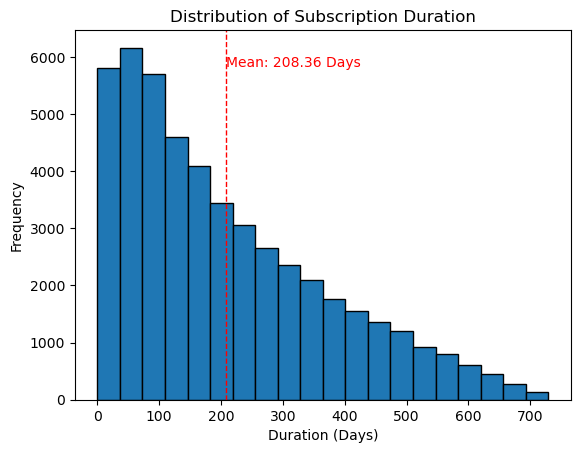

In [59]:
avg_duration = np.mean(sub_duration['SUB_DURATION_DAYS'])
plt.hist(sub_duration['SUB_DURATION_DAYS'], bins=20, edgecolor='black')
plt.axvline(avg_duration, color='r', linestyle='dashed', linewidth=1)
plt.text(avg_duration, plt.ylim()[1] * 0.9, f'Mean: {avg_duration:.2f} Days', color='r')
plt.title('Distribution of Subscription Duration')
plt.xlabel('Duration (Days)')
plt.ylabel('Frequency')
plt.show()

Across different brands:

In [64]:
sub_duration.BRAND.unique()

array(['RetroReel', 'CineQuest', 'LimeLight', 'Pulse', 'ChillStream'],
      dtype=object)

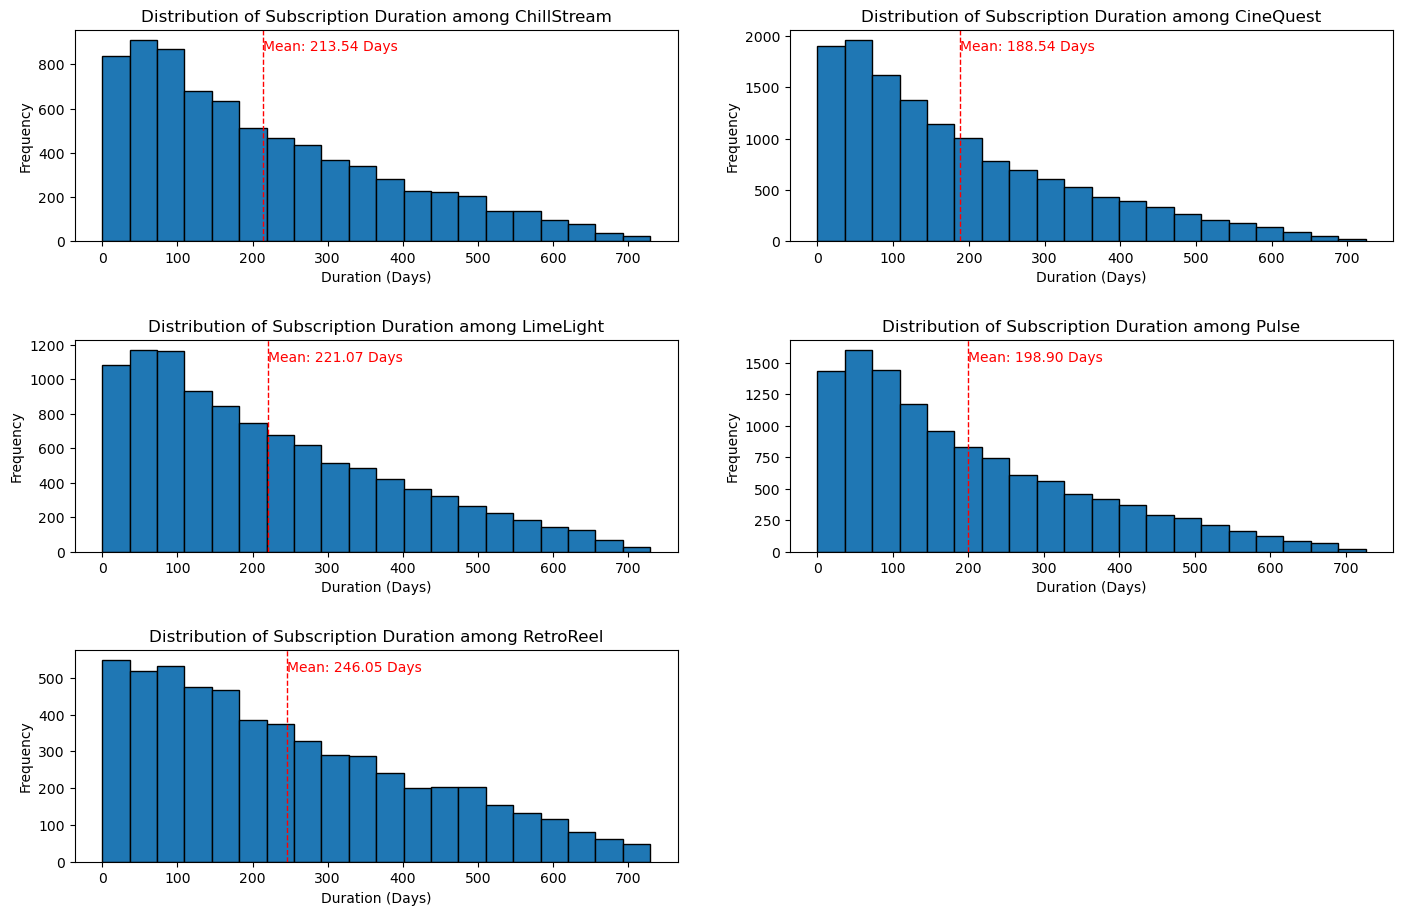

In [65]:
nrows, ncols = 3, 2

# Create the 3x2 subplot grid
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
fig.tight_layout(pad=5.0)  # Add spacing between plots

# Flatten the axes array for easier indexing
axes = axes.flatten()

brand_grouped = sub_duration.groupby('BRAND')

# Plot each brand's data in the corresponding subplot
for idx, (brand, brand_group) in enumerate(brand_grouped):
    # Reset index for the current brand group
    brand_group = brand_group.reset_index(drop=True)
    
    # Calculate the average duration for this brand
    avg_duration_brand = np.mean(brand_group['SUB_DURATION_DAYS'])
    
    # Plot histogram in the appropriate subplot
    axes[idx].hist(brand_group['SUB_DURATION_DAYS'], bins=20, edgecolor='black')
    axes[idx].axvline(avg_duration_brand, color='r', linestyle='dashed', linewidth=1)
    axes[idx].text(avg_duration_brand, axes[idx].get_ylim()[1] * 0.9, 
                   f'Mean: {avg_duration_brand:.2f} Days', color='r')
    
    # Set title and labels
    axes[idx].set_title('Distribution of Subscription Duration among ' + str(brand))
    axes[idx].set_xlabel('Duration (Days)')
    axes[idx].set_ylabel('Frequency')

# Remove any unused subplots
if len(brand_grouped) < nrows * ncols:
    for i in range(len(brand_grouped), nrows * ncols):
        fig.delaxes(axes[i])

# Display the plot
plt.show()